Installing Necessary Libraries

In [21]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import multiprocessing
from functools import partial
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np


Reading CSV Files

In [22]:
# Define the path to dataset folder
dataset_folder = r"C:\Users\Akshata S\Desktop\avatar genaration\facedataset"

# Read the CSV files
landmarks_df = pd.read_csv(f"{dataset_folder}/list_landmarks_align_celeba.csv")
bbox_df = pd.read_csv(f"{dataset_folder}/list_bbox_celeba.csv")
eval_partition_df = pd.read_csv(f"{dataset_folder}/list_eval_partition.csv")
attr_df = pd.read_csv(f"{dataset_folder}/list_attr_celeba.csv")


Listing Files in the "img_align_celeba" Folder

In [23]:
# the path to the "img_align_celeba" folder
img_folder = f"{dataset_folder}/img_align_celeba"

# List files in the folder
img_files = os.listdir(img_folder)

# Display the first few file names
img_files[:5]  


['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']

Loading Sample Images using OpenCV

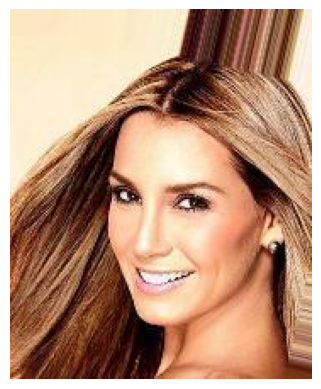

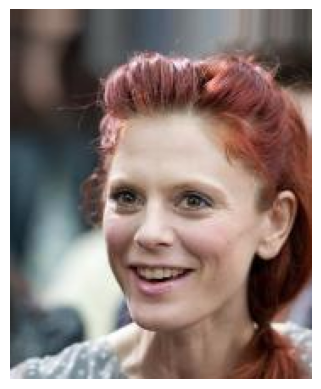

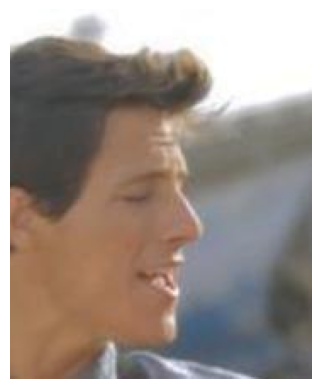

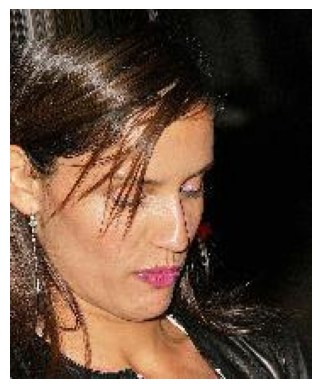

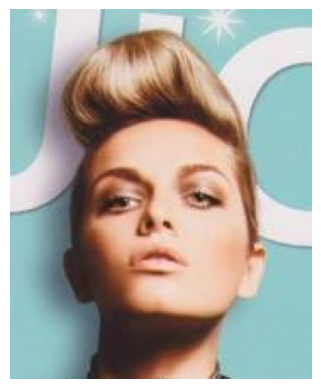

In [24]:
# Load and display the first few sample images
num_samples = 5  

for img_file in img_files[:num_samples]:
    img_path = os.path.join(img_folder, img_file)
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [25]:
print("Structure of landmarks_df:")
print(landmarks_df.info())


Structure of landmarks_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_id      202599 non-null  object
 1   lefteye_x     202599 non-null  int64 
 2   lefteye_y     202599 non-null  int64 
 3   righteye_x    202599 non-null  int64 
 4   righteye_y    202599 non-null  int64 
 5   nose_x        202599 non-null  int64 
 6   nose_y        202599 non-null  int64 
 7   leftmouth_x   202599 non-null  int64 
 8   leftmouth_y   202599 non-null  int64 
 9   rightmouth_x  202599 non-null  int64 
 10  rightmouth_y  202599 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 17.0+ MB
None


In [26]:
print("\nFirst few rows of landmarks_df:")
print(landmarks_df.head())



First few rows of landmarks_df:
     image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg         69        109         106         113      77     142   
1  000002.jpg         69        110         107         112      81     135   
2  000003.jpg         76        112         104         106     108     128   
3  000004.jpg         72        113         108         108     101     138   
4  000005.jpg         66        114         112         112      86     119   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0           73          152           108           154  
1           70          151           108           153  
2           74          156            98           158  
3           71          155           101           151  
4           71          147           104           150  


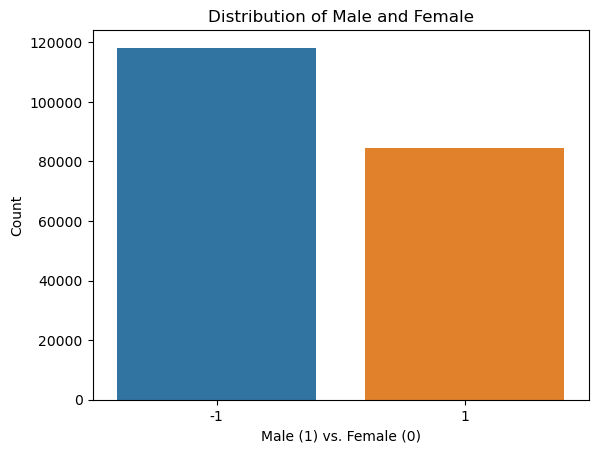

In [27]:
# Create a count plot for the "Male" column
sns.countplot(x='Male', data=attr_df)
plt.title('Distribution of Male and Female')
plt.xlabel('Male (1) vs. Female (0)')
plt.ylabel('Count')
plt.show()


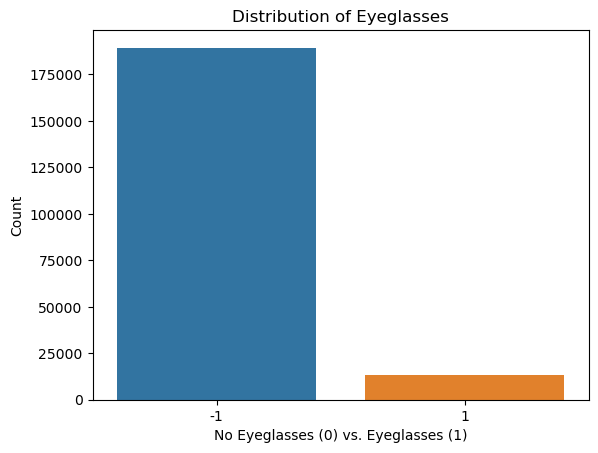

In [28]:
# Create a count plot for the "Eyeglasses" column
sns.countplot(x='Eyeglasses', data=attr_df)
plt.title('Distribution of Eyeglasses')
plt.xlabel('No Eyeglasses (0) vs. Eyeglasses (1)')
plt.ylabel('Count')
plt.show()

In [29]:
# Check for missing values in landmarks_df
missing_values_landmarks = landmarks_df.isnull().sum()

# Check for missing values in bbox_df
missing_values_bbox = bbox_df.isnull().sum()

# Check for missing values in eval_partition_df
missing_values_eval_partition = eval_partition_df.isnull().sum()

# Check for missing values in attr_df
missing_values_attr = attr_df.isnull().sum()

# Display columns with missing values (where sum is greater than 0)
print("Columns with missing values in landmarks_df:")
print(missing_values_landmarks[missing_values_landmarks > 0])

print("Columns with missing values in bbox_df:")
print(missing_values_bbox[missing_values_bbox > 0])

print("Columns with missing values in eval_partition_df:")
print(missing_values_eval_partition[missing_values_eval_partition > 0])

print("Columns with missing values in attr_df:")
print(missing_values_attr[missing_values_attr > 0])

Columns with missing values in landmarks_df:
Series([], dtype: int64)
Columns with missing values in bbox_df:
Series([], dtype: int64)
Columns with missing values in eval_partition_df:
Series([], dtype: int64)
Columns with missing values in attr_df:
Series([], dtype: int64)


Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


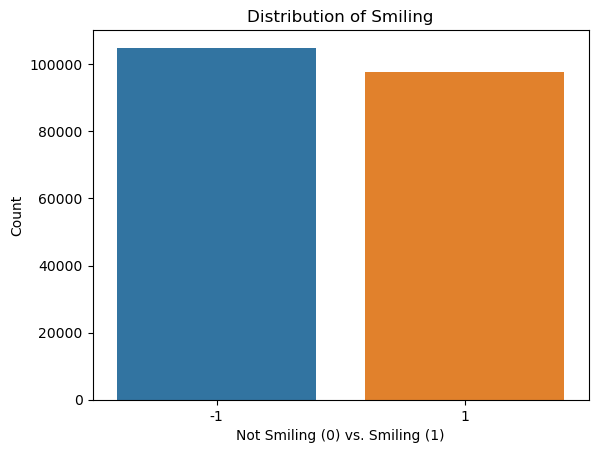

In [30]:
# Checking the column names in DataFrame to ensure 'Gender' exists and is spelled correctly
print(attr_df.columns)

sns.countplot(x='Smiling', data=attr_df)
plt.title('Distribution of Smiling')
plt.xlabel('Not Smiling (0) vs. Smiling (1)')
plt.ylabel('Count')
plt.show()


In [31]:
# Select relevant columns for feature extraction
selected_features = attr_df[['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
                                 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
                                 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows',
                                 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                                 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
                                 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
                                 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
                                 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
                                 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
                                 'Wearing_Necktie', 'Young']]

# Optionally, you can convert the selected features to a NumPy array for further processing
selected_features_array = selected_features.to_numpy()
print(selected_features)
print("display the first few rows to get a glimpse of the data")
print(selected_features.head())

        5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  Bald  \
0                     -1                1           1               -1    -1   
1                     -1               -1          -1                1    -1   
2                     -1               -1          -1               -1    -1   
3                     -1               -1           1               -1    -1   
4                     -1                1           1               -1    -1   
...                  ...              ...         ...              ...   ...   
202594                -1               -1           1               -1    -1   
202595                -1               -1          -1               -1    -1   
202596                -1               -1          -1               -1    -1   
202597                -1                1           1               -1    -1   
202598                -1                1           1               -1    -1   

        Bangs  Big_Lips  Big_Nose  Blac

Label Encoding

In [32]:
# Create a label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the column
attr_df['Male_encoded'] = label_encoder.fit_transform(attr_df['Male'])


One-Hot Encoding

In [33]:
# Map -1 to 0 and 1 to 1 for all binary attributes (excluding 'image_id')
binary_attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

for attribute in binary_attributes:
    attr_df[attribute] = (attr_df[attribute] + 1) // 2

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
data = pd.read_csv(f"{dataset_folder}/list_attr_celeba.csv")

# Define the attributes you want to predict
attributes_to_predict = ['Smiling', 'Male', 'Wavy_Hair']  # You can choose from the list of attributes

# Split the data into features (X) and labels (y)
X = data.drop(['image_id'] + attributes_to_predict, axis=1)
y = data[attributes_to_predict]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (if needed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a logistic regression model for each attribute
models = {}
for attribute in attributes_to_predict:
    model = LogisticRegression()
    model.fit(X_train, y_train[attribute])
    models[attribute] = model

# Predict attributes on the test set
y_pred = {}
for attribute in attributes_to_predict:
    y_pred[attribute] = models[attribute].predict(X_test)

# Calculate accuracy for each attribute
accuracy_scores = {}
for attribute in attributes_to_predict:
    accuracy_scores[attribute] = accuracy_score(y_test[attribute], y_pred[attribute])

# Print accuracy scores
for attribute in attributes_to_predict:
    print(f'Accuracy for {attribute}: {accuracy_scores[attribute]}')


Accuracy for Smiling: 0.8527887462981244
Accuracy for Male: 0.9326505429417572
Accuracy for Wavy_Hair: 0.7669792694965449
